In [1352]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import warnings
warnings.filterwarnings('ignore')

In [1381]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
import sklearn.cluster as cluster
import sklearn.metrics as metrics
from sklearn.metrics import silhouette_score

In [1354]:
df = pd.read_csv("/kaggle/input/a2-data4/A2Q3.csv")
df.index = df.index + 1

In [1355]:
df

,X,Y
1,2.635500,-1.859490
2,2.350513,-1.749326
3,3.562892,1.659910
4,4.709932,1.232025
5,3.999698,0.262955
...,...,...
396,0.284160,0.701929
397,4.086143,0.595677
398,3.342553,1.351409
399,4.341745,0.051792


<AxesSubplot:xlabel='X', ylabel='Y'>

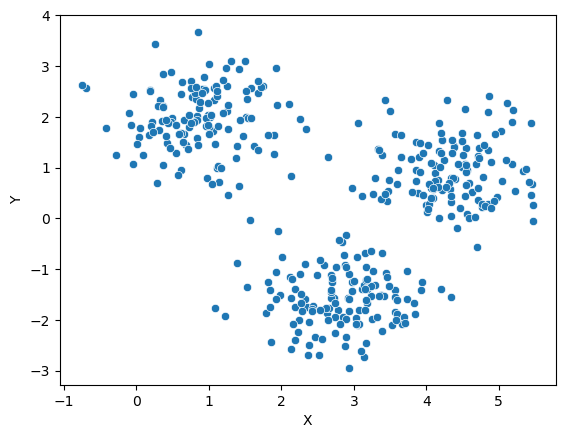

In [1356]:
sns.scatterplot(x='X', y='Y', data=df)

In [1357]:
def EM_Algo():
    x = 1
    lat_clust = []
    lat = []
    
    for i in range(k):
        lat_pt_clust = []
        for j in range(len(data_cluster[i])):
            exp = math.exp(-(data_cluster[i].iloc[j]-mean[i]).dot(np.linalg.inv(cov[i]).dot((data_cluster[i].iloc[j]-mean[i]).T))/2)
            det = np.linalg.det(cov[i])
            lat_pt_clust.append(pi[i]*exp/math.sqrt(det*2*math.pi))

        lat_clust.append(lat_pt_clust)

    sum_clust_lat = []
    sum_lat = 0
    
    for i in range(k):

        sum_clust_lat_temp = 0

        for j in range(len(data_cluster[i])):
            sum_clust_lat_temp += lat_clust[i][j]

        sum_clust_lat.append(sum_clust_lat_temp)
        sum_lat += sum_clust_lat_temp
    
    
    for i in range(k):
        lat.append(sum_clust_lat[i]/sum_lat)
    
    for i in range(k):
        mean[i] = 0
        for j in range(len(data_cluster[i])):
            mean[i] += lat_clust[i][j]*data_cluster[i].iloc[j]/sum_clust_lat[i]

    for i in range(k):
        cov[i] = 0
        for j in range(len(data_cluster[i])):
            dif_cluster_temp = np.array([(data_cluster[i].iloc[j]-mean[i]).to_numpy()])
            cov[i] += lat_clust[i][j]*(dif_cluster_temp)*(dif_cluster_temp.T)/sum_clust_lat[i]
        
    for i in range(k):
        pi[i] = lat[i]
        
    prob_clust = []
    
    for i in range(len(df)):
        prob = []
        
        for j in range(k):
            if type(cov[j]) == int:
                break
            exp_prob = math.exp(-(df.iloc[i]-mean[j]).dot(np.linalg.inv(cov[j]).dot((df.iloc[i]-mean[j]).T))/2)
            det_prob = np.linalg.det(cov[j])
            prob.append(pi[j]*exp_prob/math.sqrt(det_prob*2*math.pi))
        
        prob_clust.append(prob.index(max(prob)))

    prob_clust = pd.DataFrame(prob_clust, columns = ['cluster'])
    prob_clust.index = prob_clust.index + 1
    
    for i in range(k):
        data_cluster[i] = df.loc[prob_clust['cluster'] == i]

In [1358]:
def log_like():
    m=0
    x=1
    
    for y in range(1, 10):
        total_likelihood_temp = 0
        
        for i in range(k):

            for j in range(len(data_cluster[i])):
                total_likelihood_temp_clust = 0
                likelihood_temp = 0

                for a in range(k):
                    exp_lik = math.exp(-(data_cluster[i].iloc[j]-mean[i]).dot(np.linalg.inv(cov[i]).dot((data_cluster[i].iloc[j]-mean[i]).T))/2)
                    det_lik = np.linalg.det(cov[i])
                    likelihood_temp += np.log(pi[i]*exp_lik/math.sqrt(det_lik*2*math.pi))

                total_likelihood_temp_clust += likelihood_temp
                total_likelihood_temp += total_likelihood_temp_clust
                
        total_likelihood.append(total_likelihood_temp)
            
        if y==1:
            EM_Algo()

        elif total_likelihood[y-1] >= total_likelihood[y-2] and y!=1:
            EM_Algo()

        else:
            if m == 0:
                m = 1
                for i in range(k):
                    des_cluster.append(data_cluster[i])
            EM_Algo()

In [1359]:
dataframe = []
likelihood = []
sil_score = []

for k in range(2,10):
    total_likelihood = []
    data_cluster = []
    dataframe_temp = pd.DataFrame()
    pi = []
    des_cluster = []

# This function can be applied to cluster the dataset from scratch, but I chose to use K means clustering initially to avoid the possibility of
# getting covariance matrix as singular

#     for i in range(k):
#         pi.append(1/k)
        
#     for i in range(k):
#         data_cluster.append(df.sample(frac = pi[i]))
#         data_cluster[i] = data_cluster[i].reset_index(drop = True)

    
    km=KMeans(n_clusters=k)
    y_predicted = km.fit_predict(df[['X','Y']])
    df['cluster'] = km.labels_
    
    for i in range(k):
        data_cluster.append(df.loc[df['cluster'] == i])
        data_cluster[i] = data_cluster[i].drop(['cluster'], axis=1)
    
    df = df.drop(['cluster'], axis=1)
    
    for i in range(k):
        pi.append(len(data_cluster[i])/len(df))

    
    mean = []
    cov = []

    for i in range(k):
        mean.append(data_cluster[i].loc[:,:].mean())
        cov.append(data_cluster[i].loc[:,:].cov())
    
    log_like()
    
    for i in range(k):
        des_cluster[i]['cluster'] = i
        des_cluster[i] = pd.DataFrame(des_cluster[i])
        dataframe_temp = dataframe_temp.append(des_cluster[i])
    
    dataframe_temp = dataframe_temp.sort_index(ascending=True)
    sil_score.append(metrics.silhouette_score(df,dataframe_temp['cluster']))
    
    dataframe.append(dataframe_temp)
    likelihood.append(total_likelihood)

In [1360]:
max_likelihood = [None, None]

for i in range(2,8):
    max_likelihood.append(max(likelihood[i]))

This is the overall variation of log likelihood function with the number of clusters


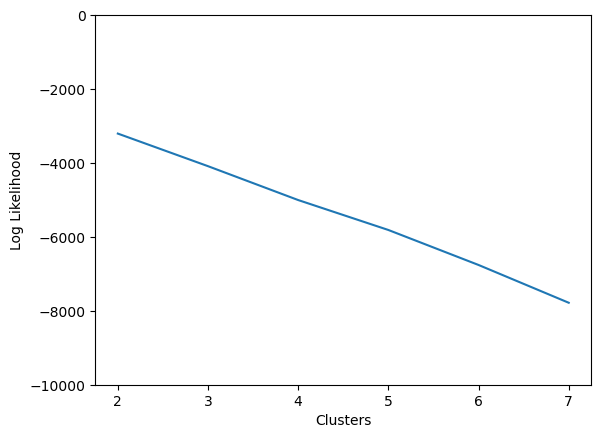

In [1361]:
print("This is the overall variation of log likelihood function with the number of clusters")
plt.ylim(-10000)
plt.xlabel('Clusters')
plt.ylabel('Log Likelihood')
plt.plot(max_likelihood)
plt.show()

This is the result if the number of clusters is 2:


<AxesSubplot:xlabel='X', ylabel='Y'>

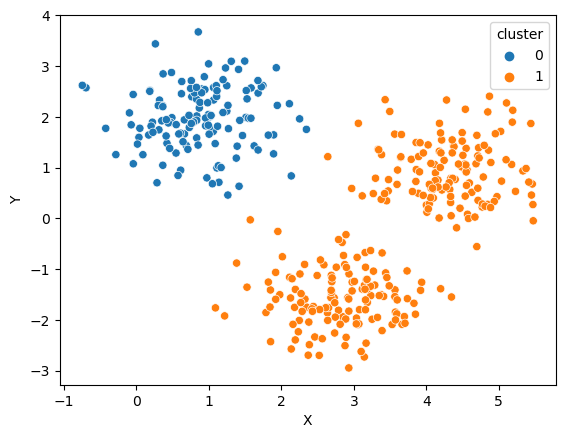

In [1362]:
print("This is the result if the number of clusters is 2:")
sns.scatterplot(x='X', y='Y', hue='cluster', data=dataframe[0])

This is the variation of log likelihood function with the number of Iterations with number of clusters taken as 2


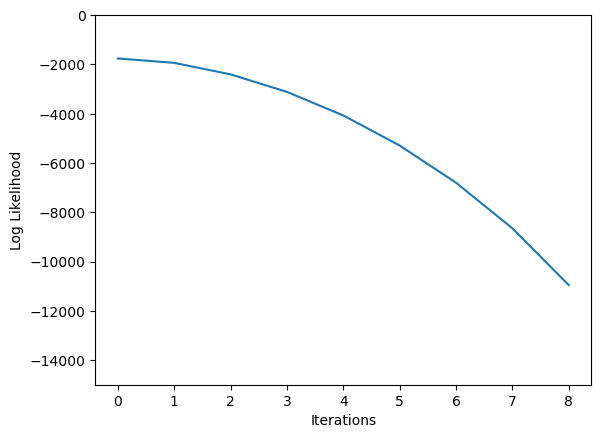

In [1363]:
print("This is the variation of log likelihood function with the number of Iterations with number of clusters taken as 2")
plt.ylim(-15000)
plt.xlabel('Iterations')
plt.ylabel('Log Likelihood')
plt.plot(likelihood[0])
plt.show()

This is the result if the number of clusters is 3:


<AxesSubplot:xlabel='X', ylabel='Y'>

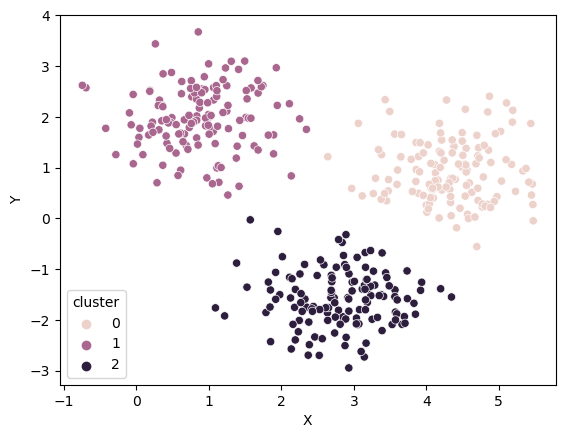

In [1364]:
print("This is the result if the number of clusters is 3:")
sns.scatterplot(x='X', y='Y', hue='cluster', data=dataframe[1])

This is the variation of log likelihood function with the number of Iterations with number of clusters taken as 3


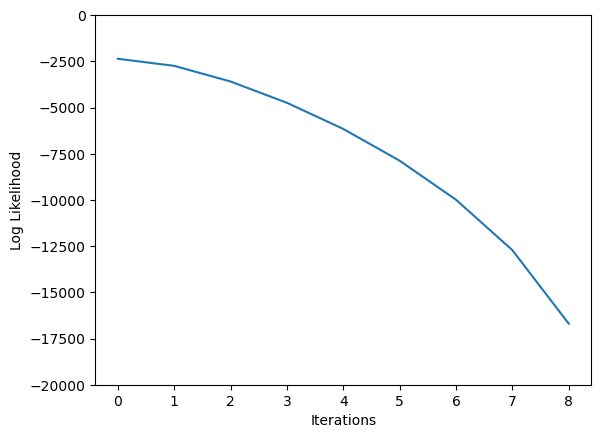

In [1365]:
print("This is the variation of log likelihood function with the number of Iterations with number of clusters taken as 3")
plt.ylim(-20000)
plt.xlabel('Iterations')
plt.ylabel('Log Likelihood')
plt.plot(likelihood[1])
plt.show()

This is the result if the number of clusters is 4:


<AxesSubplot:xlabel='X', ylabel='Y'>

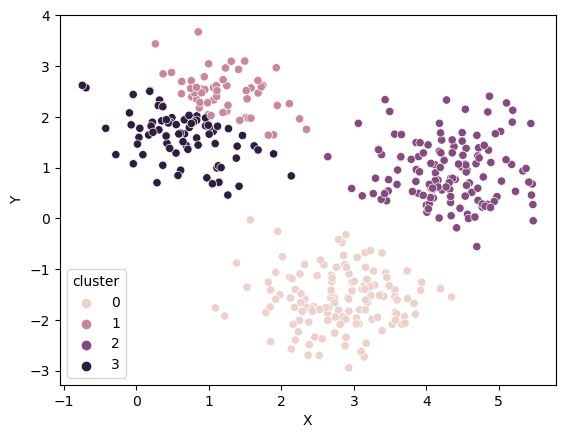

In [1366]:
print("This is the result if the number of clusters is 4:")
sns.scatterplot(x='X', y='Y', hue='cluster', data=dataframe[2])

This is the variation of log likelihood function with the number of Iterations with number of clusters taken as 4


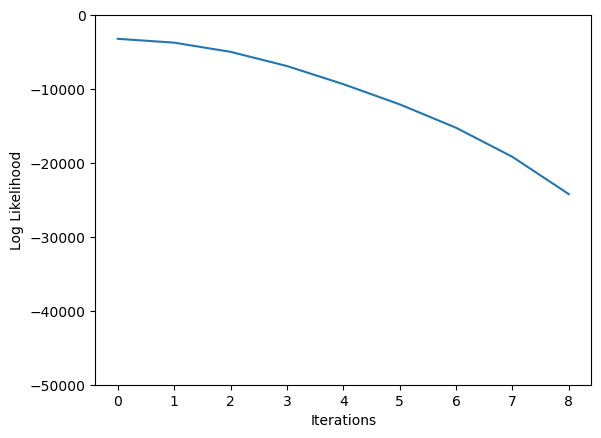

In [1367]:
print("This is the variation of log likelihood function with the number of Iterations with number of clusters taken as 4")
plt.ylim(-50000)
plt.xlabel('Iterations')
plt.ylabel('Log Likelihood')
plt.plot(likelihood[2])
plt.show()

This is the result if the number of clusters is 5:


<AxesSubplot:xlabel='X', ylabel='Y'>

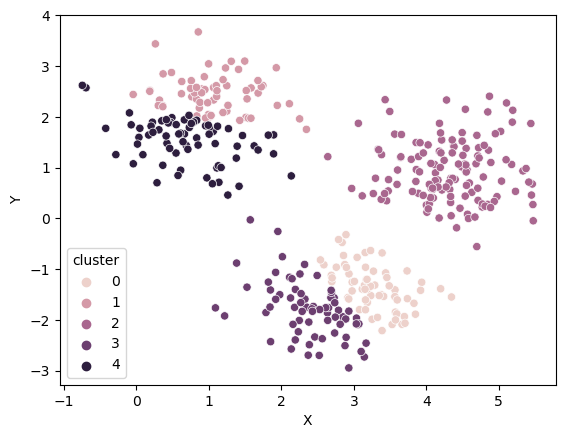

In [1368]:
print("This is the result if the number of clusters is 5:")
sns.scatterplot(x='X', y='Y', hue='cluster', data=dataframe[3])

This is the variation of log likelihood function with the number of Iterations with number of clusters taken as 5


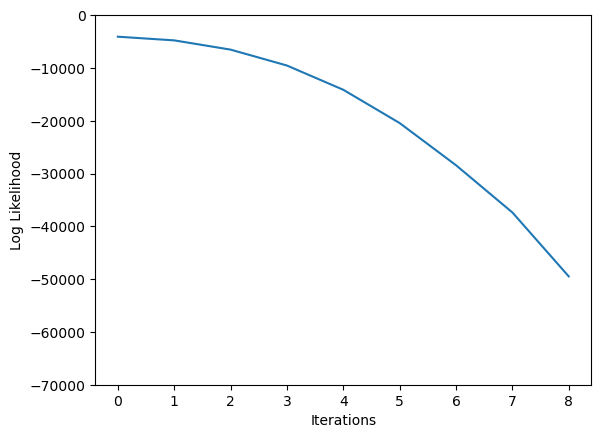

In [1369]:
print("This is the variation of log likelihood function with the number of Iterations with number of clusters taken as 5")
plt.ylim(-70000)
plt.xlabel('Iterations')
plt.ylabel('Log Likelihood')
plt.plot(likelihood[3])
plt.show()

This is the result if the number of clusters is 6:


<AxesSubplot:xlabel='X', ylabel='Y'>

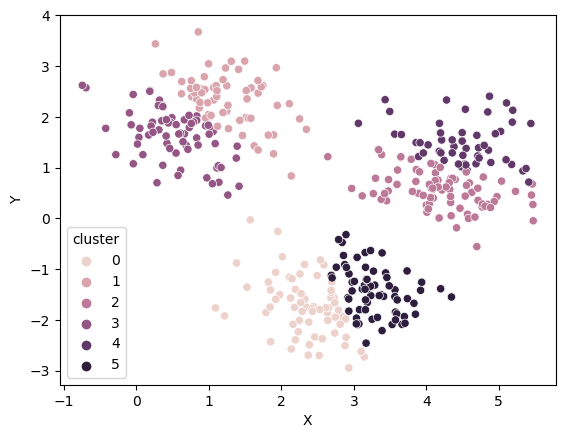

In [1370]:
print("This is the result if the number of clusters is 6:")
sns.scatterplot(x='X', y='Y', hue='cluster', data=dataframe[4])

This is the variation of log likelihood function with the number of Iterations with number of clusters taken as 5


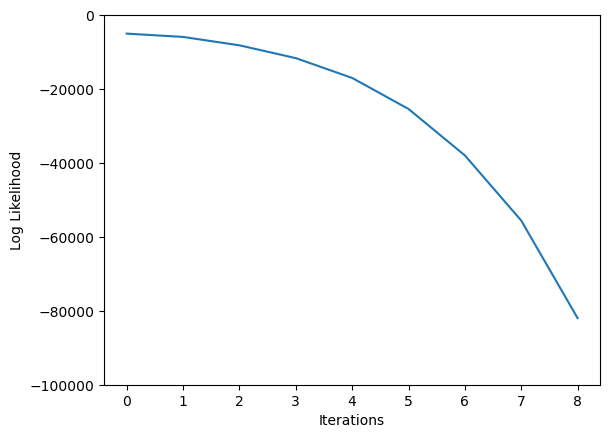

In [1371]:
print("This is the variation of log likelihood function with the number of Iterations with number of clusters taken as 5")
plt.ylim(-100000)
plt.xlabel('Iterations')
plt.ylabel('Log Likelihood')
plt.plot(likelihood[4])
plt.show()

This is the result if the number of clusters is 7:


<AxesSubplot:xlabel='X', ylabel='Y'>

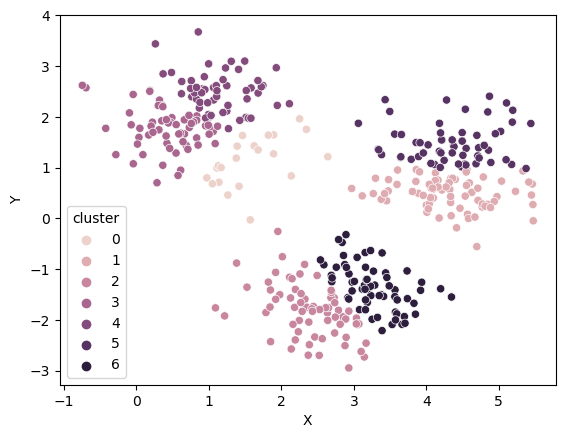

In [1372]:
print("This is the result if the number of clusters is 7:")
sns.scatterplot(x='X', y='Y', hue='cluster', data=dataframe[5])

This is the variation of log likelihood function with the number of Iterations with number of clusters taken as 7


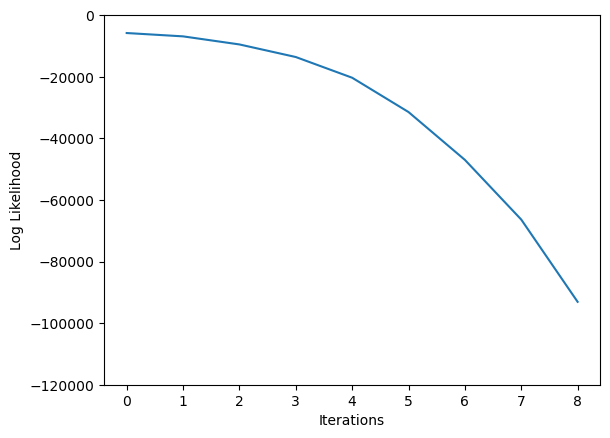

In [1373]:
print("This is the variation of log likelihood function with the number of Iterations with number of clusters taken as 7")
plt.ylim(-120000)
plt.xlabel('Iterations')
plt.ylabel('Log Likelihood')
plt.plot(likelihood[5])
plt.show()

In [1374]:
silhoutte_score = [None, None]

for i in range(0,8):
    silhoutte_score.append(sil_score[i])

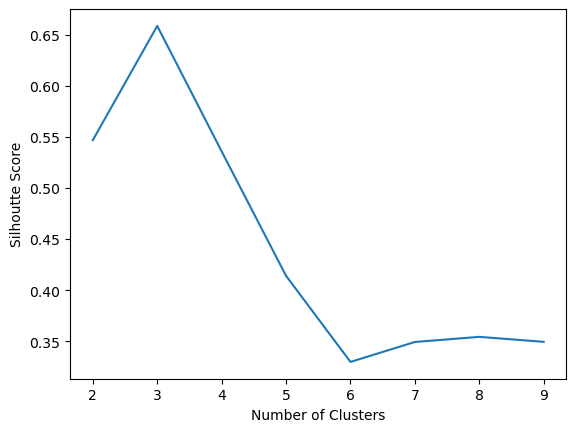

In [1375]:
plt.ylabel('Silhoutte Score')
plt.xlabel('Number of Clusters')
plt.plot(silhoutte_score)
plt.show()